# **Importation des données**

In [1]:
import kagglehub
import os
import shutil
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.metrics import silhouette_score

In [2]:
# Download latest version
path = kagglehub.dataset_download("danielvalyano/abstract-paintings")

print("Path to dataset files:", path)

100%|██████████| 443M/443M [00:21<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danielvalyano/abstract-paintings/versions/2


In [ ]:
"""folder_path = "/content/clusters"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Dossier supprimé")
else:
    print("Le dossier n'existe pas.")"""

In [3]:
source_root = path + "/img"
target_root = "/content/images"

for root, dirs, files in os.walk(source_root):
    rel_path = os.path.relpath(root, source_root)
    target_dir = os.path.join(target_root, rel_path)

    os.makedirs(target_dir, exist_ok=True)

    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            shutil.copy(
                os.path.join(root, file),
                os.path.join(target_dir, file)
                )

# **Regroupement des images par ton de couleur**

### Détermination du nombre de groupes dans les données

In [4]:
IMAGE_DIR = "/content/images"
CLUSTER_OUTPUT = "/content/clusters"
IMG_SIZE = (128, 128)

In [5]:
#Détermination des couleurs dominantes
def dominant_color_hsv(image_path, k=3):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixels = img.reshape(-1, 3)

    kmeans = KMeans(n_clusters=k, n_init=10)
    labels = kmeans.fit_predict(pixels)

    counts = np.bincount(labels)
    dominant = kmeans.cluster_centers_[counts.argmax()]
    return dominant

# Chargement des images
image_paths = []
colors = []

for file in os.listdir(IMAGE_DIR):
    if file.lower().endswith(("jpg", "jpeg", "png")):
        path = os.path.join(IMAGE_DIR, file)
        image_paths.append(path)
        colors.append(dominant_color_hsv(path))

colors = np.array(colors)

In [6]:
#Détermination du nombre de clusters optimal avec l'agorithme du coude
K = range(2, 11)
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(colors)
    score = silhouette_score(colors, labels)
    sil_scores.append(score)
    print(f"Pour {k} clusturs, silhouette = {score}")

# Optionnel : meilleur nombre de clusters
best_k = K[sil_scores.index(max(sil_scores))]
print(f"Nombre optimal de clusters : {best_k}")

Pour 2 clusturs, silhouette = 0.38082849028141086
Pour 3 clusturs, silhouette = 0.4500008299036071
Pour 4 clusturs, silhouette = 0.4092485860486096
Pour 5 clusturs, silhouette = 0.4070011845353501
Pour 6 clusturs, silhouette = 0.39757333546338086
Pour 7 clusturs, silhouette = 0.40073514112136155
Pour 8 clusturs, silhouette = 0.37523444450996646
Pour 9 clusturs, silhouette = 0.36564987754787204
Pour 10 clusturs, silhouette = 0.3679241862671082
Nombre optimal de clusters : 3


### Regroupement

In [7]:
FINAL_K = 3

os.makedirs(CLUSTER_OUTPUT, exist_ok=True)

# Fonction de détermination des tons pour 3 clusters
def tone_3_classes(h, s, v):
    if s < 40:
        return "neutre"
    else:
        if h < 60 or h > 300:
            return "chaud"
        else:
            return "froid"

#Modèle de Kmeans
kmeans = KMeans(n_clusters=FINAL_K, n_init=20, random_state=42)
labels = kmeans.fit_predict(colors)
centers = kmeans.cluster_centers_

# Attribution des tons aux clusters
cluster_names = {i: tone_3_classes(*centers[i]) for i in range(FINAL_K)}

# Regroupement des images
for path, label in zip(image_paths, labels):
    tone = cluster_names[label]
    target_dir = os.path.join(CLUSTER_OUTPUT, tone)
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(path, os.path.join(target_dir, os.path.basename(path)))

# Affichage résumé
print("Regroupement terminé")
print("Tons détectés :", set(cluster_names.values()))
print("\nRépartition par cluster :")
for i in range(FINAL_K):
    count = np.sum(labels == i)
    h, s, v = centers[i]
    print(f"Cluster {i} ({cluster_names[i]}): {count} images | H={h:.1f}, S={s:.1f}, V={v:.1f}")

Regroupement terminé
Tons détectés : {'neutre', 'chaud', 'froid'}

Répartition par cluster :
Cluster 0 (chaud): 1784 images | H=51.3, S=187.1, V=167.0
Cluster 1 (neutre): 3702 images | H=43.5, S=31.2, V=211.4
Cluster 2 (froid): 1905 images | H=73.2, S=64.4, V=78.2


# Création du VAE

### Chargement des données

In [8]:
IMG_SIZE = 128
LATENT_DIM = 128
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
CLUSTERS = {
    "chaud": 0,
    "neutre":  1,
    "froid":   2
}
NUM_CLUSTERS = len(CLUSTERS)

In [21]:
# Chargement des données
def load_cluster_dataset(root_dir):
    images = []
    labels = []

    for cluster_name, cluster_id in CLUSTERS.items():
        cluster_path = os.path.join(root_dir, cluster_name)

        for fname in os.listdir(cluster_path):
            img_path = os.path.join(cluster_path, fname)
            img = keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img = keras.utils.img_to_array(img) / 255.0
            images.append(img)
            labels.append([cluster_id])

    return np.array(images, dtype="float32"), np.array(labels, dtype="int32")


### Définition du VAE

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

In [11]:
def build_encoder():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    for f in [32, 64, 128, 256]:
        x = layers.Conv2D(f, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [12]:
def build_decoder():
    z_input = keras.Input(shape=(LATENT_DIM,))
    cluster_input = keras.Input(shape=(1,), dtype="int32")

    cluster_emb = layers.Embedding(NUM_CLUSTERS, LATENT_DIM)(cluster_input)
    cluster_emb = layers.Flatten()(cluster_emb)

    x = layers.Add()([z_input, cluster_emb])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    for f in [128, 64, 32]:
        x = layers.Conv2DTranspose(f, 4, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="sigmoid")(x)
    return keras.Model([z_input, cluster_input], outputs, name="decoder")

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reco_loss_tracker = keras.metrics.Mean(name="reco_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, x, training=False):
        _, _, z = self.encoder(x, training=training)
        batch = tf.shape(x)[0]
        dummy_labels = tf.zeros((batch, 1), dtype=tf.int32)
        return self.decoder([z, dummy_labels], training=training)

    @property

    def metrics(self):
        return [self.total_loss_tracker, self.reco_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder([z, labels], training=True)

            reco_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, x_hat),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = reco_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reco_loss_tracker.update_state(reco_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reco_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [22]:
def train_vae(cluster_path):
    images, labels = load_cluster_dataset(cluster_path)

    dataset = (
        tf.data.Dataset.from_tensor_slices((images, labels))
        .shuffle(len(images))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder=encoder, decoder=decoder)
    vae.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE))
    vae.fit(dataset, epochs=EPOCHS)

    return vae, encoder, decoder

### Entrainement

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configuré avec memory growth")
    except RuntimeError as e:
        print(e)

GPU configuré avec memory growth


In [23]:
# Entraîner le VAE
vae, encoder, decoder = train_vae(CLUSTER_OUTPUT)

Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - kl_loss: 18.0404 - loss: 10911.2402 - reco_loss: 10893.2012
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - kl_loss: 72.3414 - loss: 9605.2197 - reco_loss: 9532.8789
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 81.9704 - loss: 9428.3242 - reco_loss: 9346.3516
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 90.0257 - loss: 9318.8545 - reco_loss: 9228.8291
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - kl_loss: 102.1748 - loss: 9172.3779 - reco_loss: 9070.2031
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 105.4068 - loss: 9085.4697 - reco_loss: 8980.0635
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - kl_loss: 108.4766 - loss: 9055.7148 - reco_loss: 8947.2383
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 110.5436 - loss: 9012.9521 - reco_loss: 8902.4072
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - kl_loss: 113.7523 - loss:

In [25]:
#Construction du modèle
dummy = tf.zeros((1, 128, 128, 3))
_ = vae(dummy)

# Sauvegarder le modèle
vae.save_weights("vae_weights.weights.h5")

In [26]:
vae.save("vae_model.keras")

### Tests

In [15]:
def generate_images(decoder, cluster_name, n):
    if cluster_name not in CLUSTERS:
        raise ValueError(f"Cluster inconnu : {cluster_name}")

    z = np.random.normal(size=(n, LATENT_DIM))
    labels = np.full((n, 1), CLUSTERS[cluster_name], dtype=np.int32)
    images = decoder.predict([z, labels])

    fig, axes = plt.subplots(2, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis("off")
    plt.suptitle(f"Génération — {cluster_name}")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


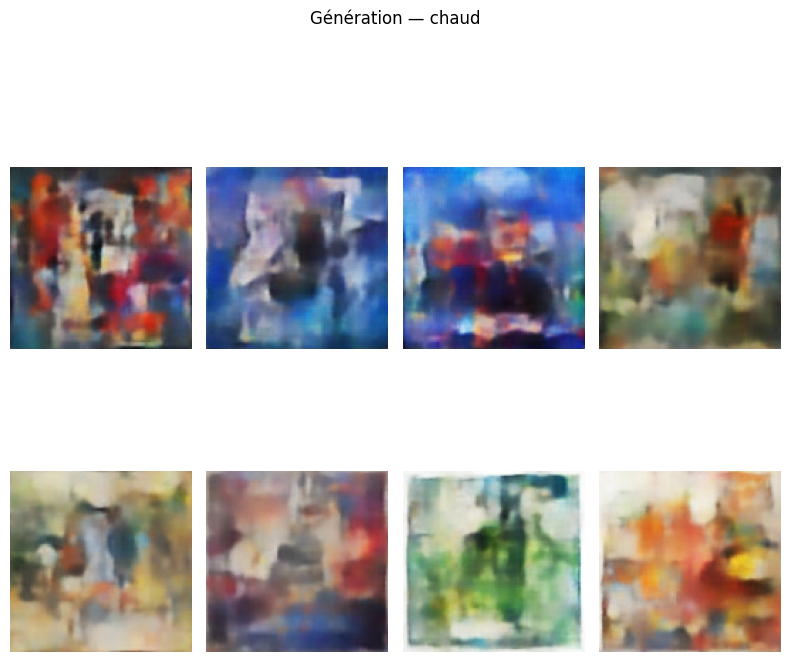

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


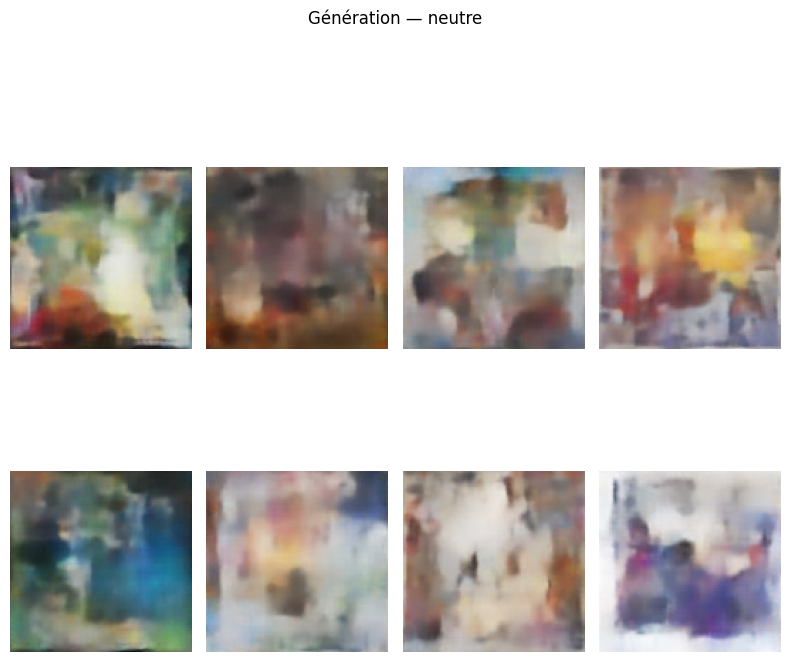

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


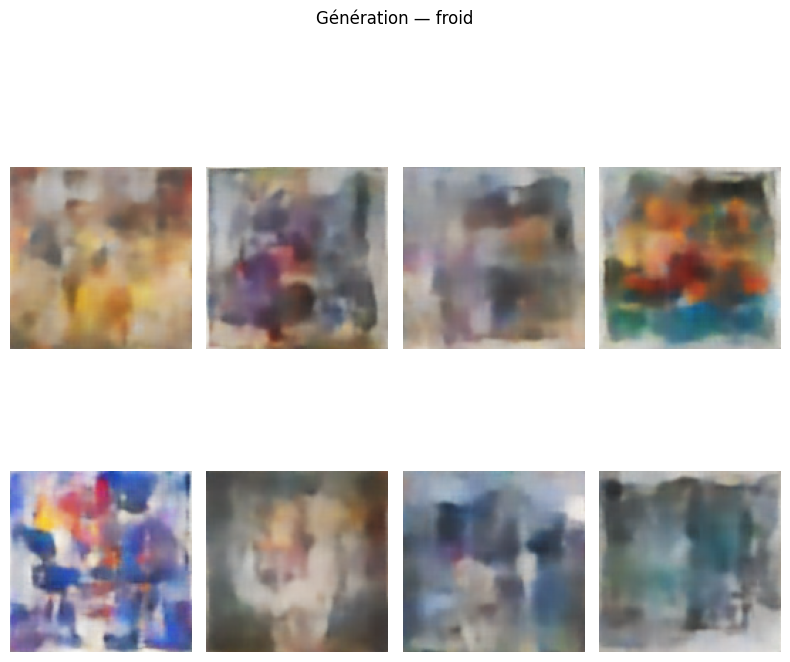

In [27]:
# Générer des images pour chaque cluster
for cluster_name in CLUSTERS.keys():
    generate_images(decoder, cluster_name, n=8)

In [28]:
from google.colab import files

files.download('vae_weights.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
files.download('vae_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>